<a href="https://colab.research.google.com/github/CodeSage54/Machine-Learning/blob/main/Walmart_Sales_TimeSeries_Forecasting/Walmart_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

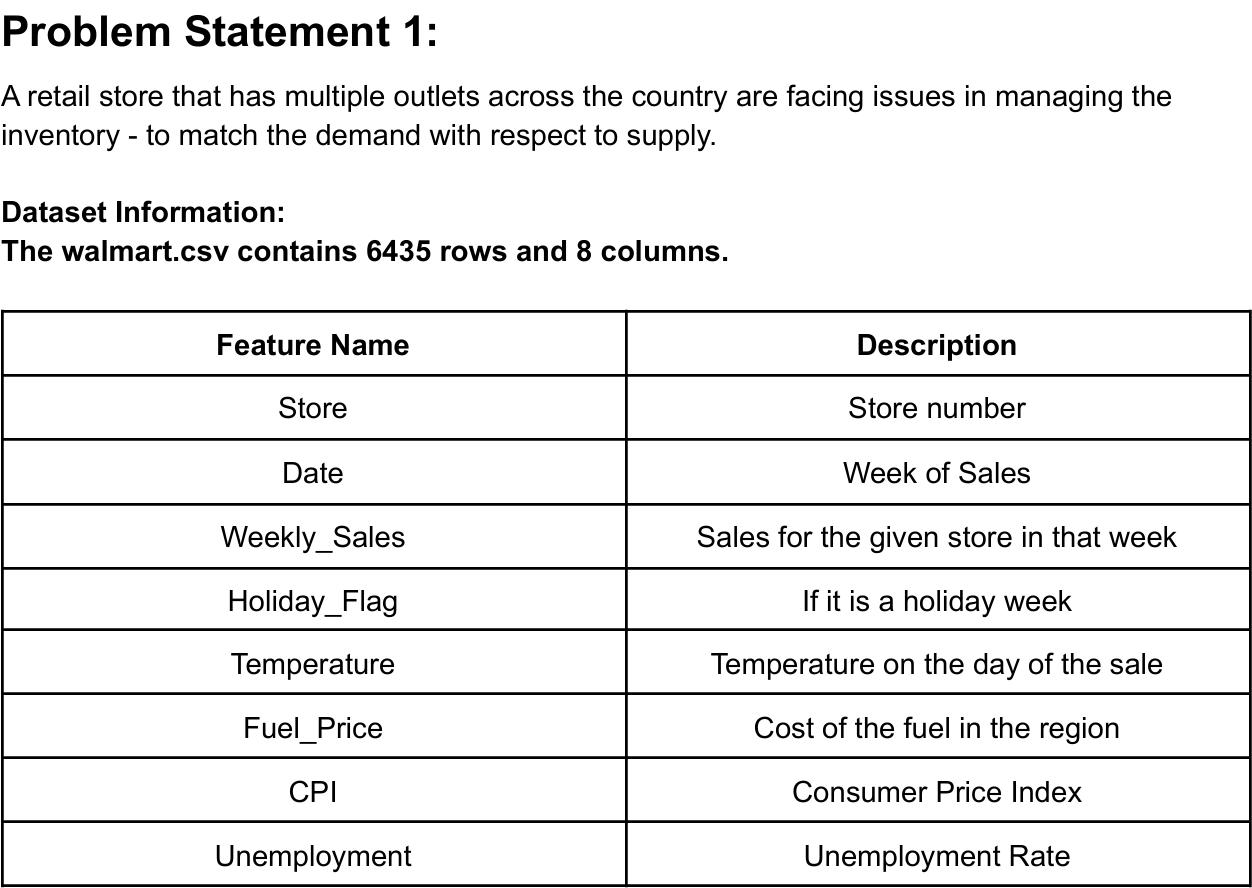

**Time Series Analysis of Walmart store sales**

**Problem Statement:**

1. You are provided with the weekly sales data for their various outlets. Use statistical analysis, EDA, outlier analysis, and handle the missing values to come up with various insights that can give them a clear perspective on the following:
  
    a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

    b. If the weekly sales show a seasonal trend, when and what could be the reason?

    c. Does temperature affect the weekly sales in any manner?
    
    d. How is the Consumer Price index affecting the weekly sales of various stores?

    e. Top performing stores according to the historical data.
    
    f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.

2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks.


**[Expand the Sections below to view the code and run results]** **

# EDA and Section 1 of Problem Statement

In [1]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 9.6 MB/s eta 0:00:00


In [2]:
# Import dependencies
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# For time series and forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For ML forecasting
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
#Load dataset
df_sales = pd.read_csv('/content/Walmart DataSet.csv', index_col = 'Date', parse_dates = ['Date'] )
df_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
05-02-2010,1,1643690.90,0,42.31,2.572,211.096358,8.106
12-02-2010,1,1641957.44,1,38.51,2.548,211.242170,8.106
19-02-2010,1,1611968.17,0,39.93,2.514,211.289143,8.106
26-02-2010,1,1409727.59,0,46.63,2.561,211.319643,8.106
05-03-2010,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df_sales.index = pd.to_datetime(df_sales.index, format="%d-%m-%Y")

In [5]:
print(type(df_sales.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


**# Doing EDA on the dataset**

In [6]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [7]:
#convert all columns to lower case
df_sales.columns = df_sales.columns.str.lower()
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         6435 non-null   int64  
 1   weekly_sales  6435 non-null   float64
 2   holiday_flag  6435 non-null   int64  
 3   temperature   6435 non-null   float64
 4   fuel_price    6435 non-null   float64
 5   cpi           6435 non-null   float64
 6   unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [8]:
df_sales.isnull().sum()

,0
store,0
weekly_sales,0
holiday_flag,0
temperature,0
fuel_price,0
cpi,0
unemployment,0


In [9]:
df_sales.duplicated().sum()

np.int64(0)

**Lets do some Outlier detection**

In [10]:

# Define a common function to detect outliers
def get_outliers(df, column):
    """
    Returns a dataframe containing outliers for a given column
    using the IQR method.

    Parameters:
    df (pd.DataFrame): The input dataframe
    column (str): Column name to check for outliers

    Returns:
    pd.DataFrame: Subset of df containing outlier rows
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


In [11]:
#check outliers for unemployment
get_outliers(df_sales, 'unemployment' )['unemployment'].describe()

,unemployment
count,481.000000
mean,11.447480
std,3.891387
min,3.879000
25%,11.627000
50%,13.503000
75%,14.021000
max,14.313000


**481 outliers in Unemployment. Range 3.87 - 14.3. Median is 13.50 suggesting many outliers are on the higher side. We can leave these intact because this can be a macroeconimic condition specific to cvertain store location but can have an impact on sales.**

In [12]:
#Check possible values of holiday_flag column.
# Since this is a categorical value, we dont need to check outliers for holiday_flag
df_sales['holiday_flag'].value_counts()

,count
holiday_flag,
0,5985
1,450


In [13]:
#check outliers for cpi
get_outliers(df_sales, 'cpi' )['cpi'].describe()

,cpi
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


**No Outliers for cpi detected**

In [14]:
#check outliers for fuel_price
get_outliers(df_sales, 'fuel_price' )['fuel_price'].describe()

,fuel_price
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


**No Outliers for fuel_price**

In [15]:
#check outliers for temperature
get_outliers(df_sales, 'temperature' )['temperature'].describe()

,temperature
count,3.000000
mean,3.236667
std,4.600004
min,-2.060000
25%,1.740000
50%,5.540000
75%,5.885000
max,6.230000


**Range of temperature outliers is [-2 to 6.23]. Negative value -2 of a temperature is a valid case for a global store with various locations and so is the positve value of 6.23. 3 outliers for temperature found. Keep them intact for now as these are valid cases **

**#1.a Find if the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?**

In [16]:
# Correlation between weekly_sales and unemployment for each store
store_unemploy_corr = (
    df_sales.groupby('store')[['weekly_sales','unemployment']]
    .corr() # returns a multi-indexed dataframe because of grouping
    .iloc[1::2, 0]   # row 1,3,5... are weekly_sales vs unemployment
    .reset_index()
    .rename(columns={'weekly_sales':'weeklysales_unemployment_corr'})

)
# Remove the unemployment column. weekly
store_unemploy_corr = store_unemploy_corr[['store','weeklysales_unemployment_corr']]

# Set store as index
store_unemploy_corr = store_unemploy_corr.set_index('store')

# Rename columns to "StoreX"
store_unemploy_corr.index = store_unemploy_corr.index.map(lambda x: f"Store{x}")
store_unemploy_corr


,weeklysales_unemployment_corr
store,
Store1,-0.097955
Store2,0.066325
Store3,-0.230413
Store4,-0.337015
Store5,-0.207043
Store6,0.044251
Store7,-0.165382
Store8,-0.052580
Store9,-0.191534


In [17]:
# Find stores most negatively affected by Unemployment
store_unemploy_corr_sorted = store_unemploy_corr.sort_values(by='weeklysales_unemployment_corr')
print("Worst affected stores:\n", store_unemploy_corr_sorted.head(10))


Worst affected stores:
          weeklysales_unemployment_corr
store                                 
Store38                      -0.785290
Store44                      -0.780076
Store39                      -0.384681
Store42                      -0.356355
Store41                      -0.350630
Store4                       -0.337015
Store17                      -0.263600
Store3                       -0.230413
Store37                      -0.221287
Store5                       -0.207043


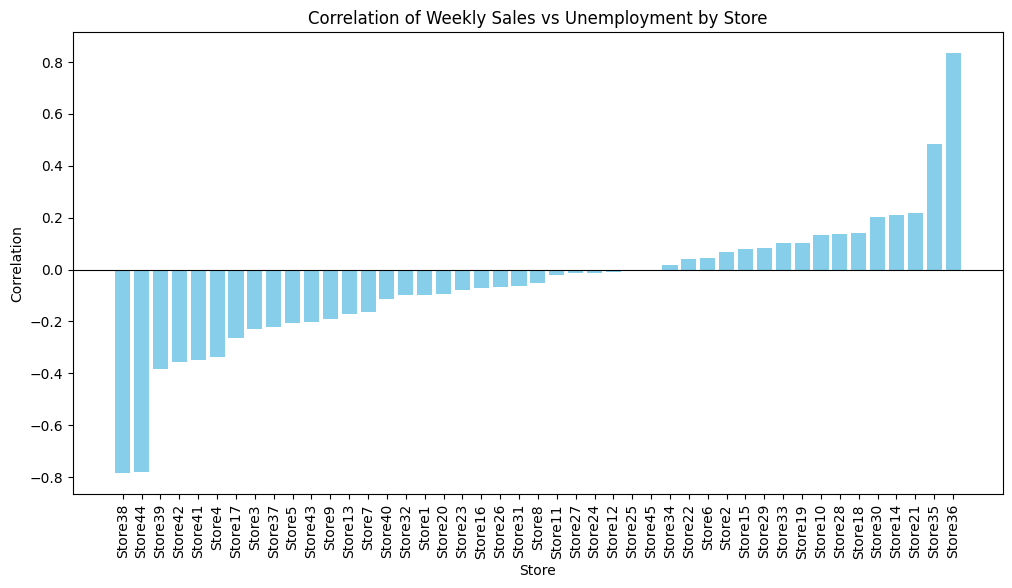

In [18]:
# Plot the Weekly Sales to Unemployment correlation for all the stores
plt.figure(figsize=(12,6))
plt.bar(store_unemploy_corr_sorted.index, store_unemploy_corr_sorted['weeklysales_unemployment_corr'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Correlation of Weekly Sales vs Unemployment by Store")
plt.xlabel("Store")
plt.ylabel("Correlation")
plt.xticks(rotation=90)
plt.show()



**#1.b If the weekly sales show a seasonal trend, when and what could be the reason?**

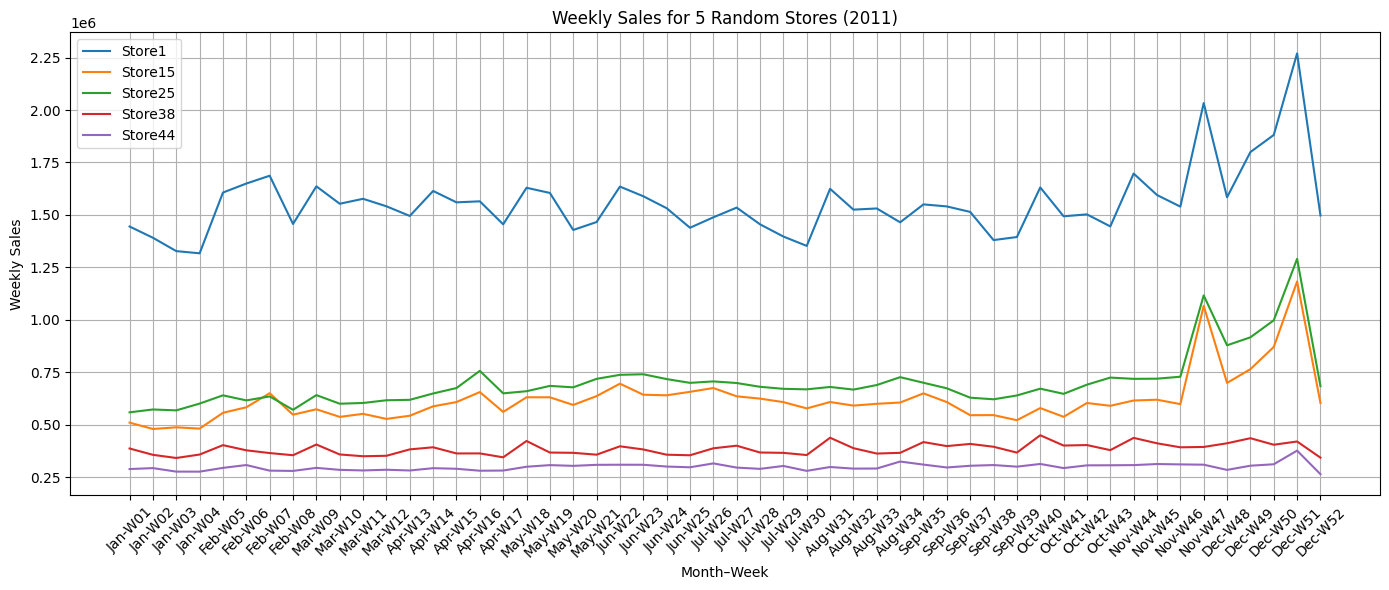

In [19]:
# First lets compare 5 random stores for weekly sales in 2011 to check on seasonal trend

df_sales_copy = df_sales.copy()
# Convert index to datetime if it's not already
#df_sales_copy.index = pd.to_datetime(df_sales_copy.index)
df_sales_copy['year'] = df_sales_copy.index.year
df_sales_copy['month'] = df_sales_copy.index.month
df_sales_copy['week'] = df_sales_copy.index.isocalendar().week

df_sales_copy['month_name'] = df_sales_copy['month'].apply(lambda x: calendar.month_abbr[x])
df_sales_copy['month_week'] = df_sales_copy['month_name'] + '-W' + df_sales_copy['week'].astype(str).str.zfill(2)

df_2011 = df_sales_copy[df_sales_copy['year'] == 2011]
random_stores = [1,15,25,38,44]

plt.figure(figsize=(14,6))

for s in random_stores:
    store_data = df_2011[df_2011['store'] == s]
    plt.plot(store_data['month_week'], store_data['weekly_sales'], label=f"Store{s}")

plt.title("Weekly Sales for 5 Random Stores (2011)")
plt.xlabel("Month–Week")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




**For 3 out 5 random stores, there is a clear spike in Nov-Dec sales probably because of Holiday season. Now lets decompose the overall sales data across all stores and see if this holds true for aggregate weekly sales for all years.**

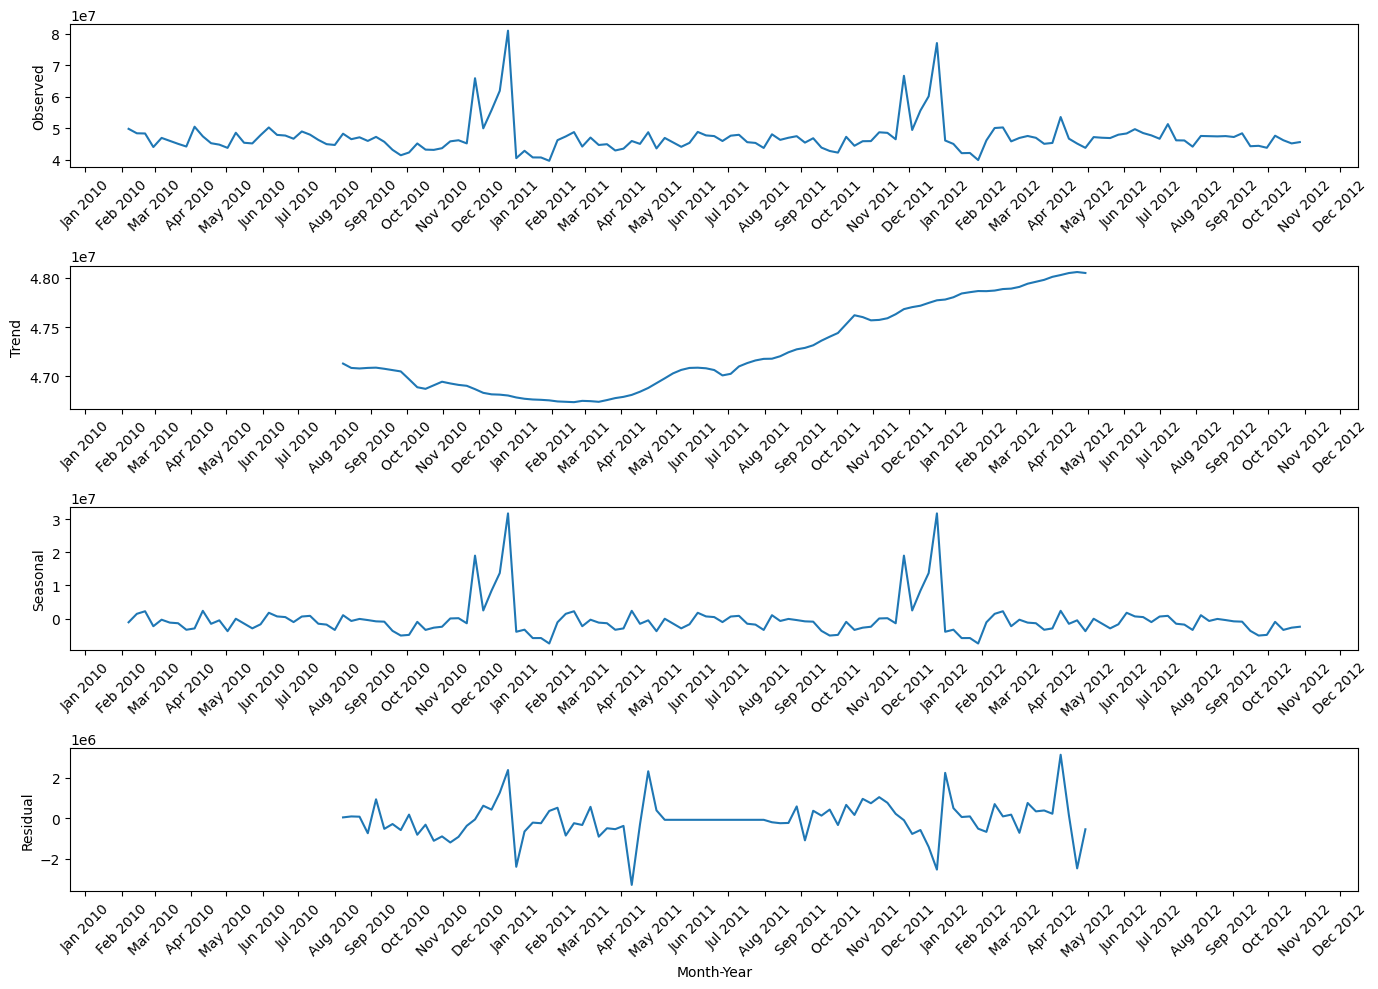

In [20]:
# Weekly aggregation of weekly sales of all stores(chain-level)
ts = df_sales_copy['weekly_sales'].resample('W').sum()

# Decompose
result = seasonal_decompose(ts, model='additive', period=52)

# Re-wrap components with the original index
trend = pd.Series(result.trend, index=ts.index)
seasonal = pd.Series(result.seasonal, index=ts.index)
resid = pd.Series(result.resid, index=ts.index)

# Plot with shared x-axis
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(ts.index, ts)
axes[0].set_ylabel("Observed")

axes[1].plot(trend.index, trend)
axes[1].set_ylabel("Trend")

axes[2].plot(seasonal.index, seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(resid.index, resid)
axes[3].set_ylabel("Residual")

# Force month-year ticks on ALL subplots
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   # tick every 2 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as Jan 2010, Feb 2010, etc.
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(labelbottom=True)

plt.xlabel("Month-Year")
plt.tight_layout()
plt.show()

**Inference (1,b):**


1.   Seasonality: Clear spike in Nov-Dec overall sales highlighting Holiday season demand. Clear dip in sales in January post Holiday season.
2.   Trend: Shows increase in Sales post March 2011.



In [21]:
# Check correlation of all features by store Id
df_sales.groupby('store').corr()

weekly_sales  holiday_flag  temperature  fuel_price  \
store                                                                     
1     weekly_sales      1.000000      0.194905    -0.222701    0.124592   
      holiday_flag      0.194905      1.000000    -0.200543   -0.085903   
      temperature      -0.222701     -0.200543     1.000000    0.228493   
      fuel_price        0.124592     -0.085903     0.228493    1.000000   
      cpi               0.225408     -0.028919     0.118503    0.755259   
...                          ...           ...          ...         ...   
45    holiday_flag      0.106357      1.000000    -0.173354   -0.066898   
      temperature      -0.201945     -0.173354     1.000000    0.125521   
      fuel_price       -0.046663     -0.066898     0.125521    1.000000   
      cpi              -0.023548     -0.029459     0.163129    0.809476   
      unemployment     -0.004041      0.004273     0.146425   -0.704611   

                         cpi  unemployment  
store                                       
1     weekly_sales  0.225408     -0.097955  
      holiday_flag -0.028919      0.082949  
      temperature   0.118503     -0.180695  
      fuel_price    0.755259     -0.513944  
      cpi           1.000000     -0.813471  
...                      ...           ...  
45    holiday_flag -0.029459      0.004273  
      temperature   0.163129      0.146425  
      fuel_price    0.809476     -0.704611  
      cpi           1.000000     -0.597744  
      unemployment -0.597744      1.000000  

[270 rows x 6 columns]

**1.c Does temperature affect the weekly sales in any manner?**

In [22]:
store_temp_corr = (
    df_sales.groupby('store')[['weekly_sales','temperature']]
    .corr() # returns a multi-indexed dataframe because of grouping
    .iloc[1::2, 0]   # row 1,3,5... are weekly_sales vs unemployment
    .reset_index()
    .rename(columns={'weekly_sales':'weeklysales_temp_corr'})

)
# Remove the unemployment column. weekly
store_temp_corr = store_temp_corr[['store','weeklysales_temp_corr']]

# Set store as index
store_temp_corr = store_temp_corr.set_index('store')

# Rename columns to "StoreX"
store_temp_corr.index = store_temp_corr.index.map(lambda x: f"Store{x}")


In [23]:
store_temp_corr_sorted = store_temp_corr.sort_values(by='weeklysales_temp_corr')


In [24]:
#Stores whose weekly sales are negatively impacted due to temperature increase
store_temp_corr_sorted[store_temp_corr_sorted['weeklysales_temp_corr']<0]

,weeklysales_temp_corr
store,
Store10,-0.432569
Store12,-0.379416
Store3,-0.377524
Store28,-0.376506
Store30,-0.330816
Store8,-0.312324
Store37,-0.300493
Store2,-0.297673
Store34,-0.278523


In [25]:
#Stores whose weekly sales are positively impacted due to temperature increase
store_temp_corr_sorted[store_temp_corr_sorted['weeklysales_temp_corr']>0]

,weeklysales_temp_corr
store,
Store7,0.015077
Store33,0.019244
Store38,0.032993
Store35,0.043392
Store23,0.056257
Store39,0.064738
Store17,0.081012
Store40,0.090598
Store43,0.095272


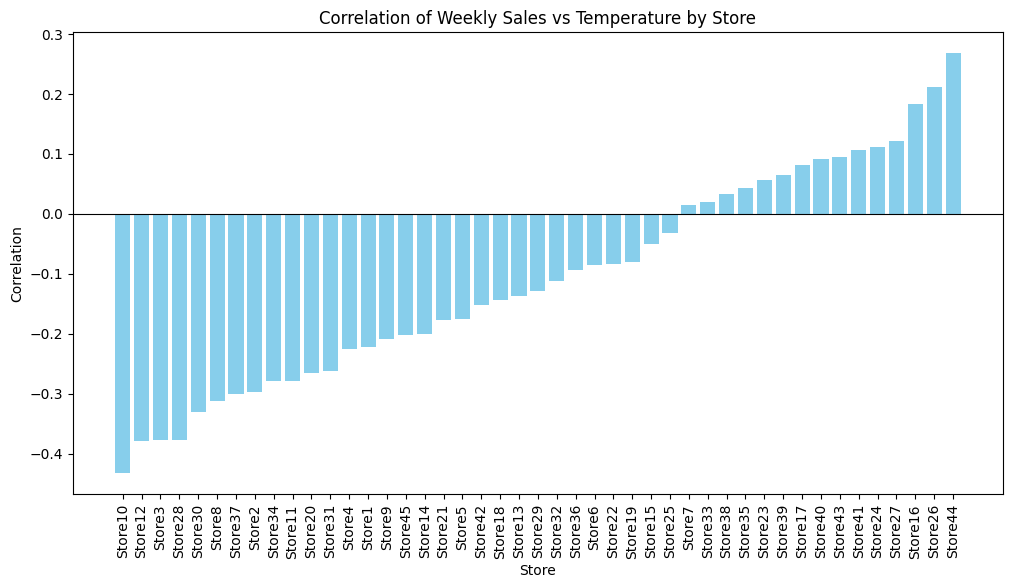

In [26]:
# Plot the Weekly Sales to Temperature correlation for all the stores
plt.figure(figsize=(12,6))
plt.bar(store_temp_corr_sorted.index, store_temp_corr_sorted['weeklysales_temp_corr'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Correlation of Weekly Sales vs Temperature by Store")
plt.xlabel("Store")
plt.ylabel("Correlation")
plt.xticks(rotation=90)
plt.show()

**Inference (1.c):** As shown above, there are 30 stores whose weekly sales are negatively impacted due to temperature rise and 15 stores whose weekly sales increase with temp rise. Store 10 is the most impacted negatively whereas Store 44 is the most impacted postively.

**1.d How is the Consumer Price index affecting the weekly sales of various stores?**

In [27]:
#Repeat the above steps as in 1.b/1.c for analysing CPI field correlation with weeklysales of stores
store_cpi_corr = (
    df_sales.groupby('store')[['weekly_sales','cpi']]
    .corr() # returns a multi-indexed dataframe because of grouping
    .iloc[1::2, 0]   # row 1,3,5... are weekly_sales vs unemployment
    .reset_index()
    .rename(columns={'weekly_sales':'weeklysales_cpi_corr'})

)
# Remove the unemployment column. weekly
store_cpi_corr = store_cpi_corr[['store','weeklysales_cpi_corr']]

# Set store as index
store_cpi_corr = store_cpi_corr.set_index('store')

# Rename columns to "StoreX"
store_cpi_corr.index = store_cpi_corr.index.map(lambda x: f"Store{x}")
store_cpi_corr_sorted = store_cpi_corr.sort_values(by='weeklysales_cpi_corr')

In [28]:
#Stores whose weekly sales are negatively impacted due to cpi
neg_cpi_corr = store_cpi_corr_sorted[store_cpi_corr_sorted['weeklysales_cpi_corr']<0]
print(f"No of Stores negatively impacted due to CPI :: {neg_cpi_corr.shape[0]}")
neg_cpi_corr

No of Stores negatively impacted due to CPI :: 20


,weeklysales_cpi_corr
store,
Store36,-0.915095
Store35,-0.424107
Store14,-0.419755
Store30,-0.298188
Store43,-0.285686
Store27,-0.213082
Store18,-0.193541
Store15,-0.174467
Store21,-0.163649


In [29]:
#Stores whose weekly sales are positively impacted due to cpi
pos_cpi_corr = store_cpi_corr_sorted[store_cpi_corr_sorted['weeklysales_cpi_corr']>0]
print(f"No of Stores positvely impacted due to CPI :: {pos_cpi_corr.shape[0]}")
pos_cpi_corr

No of Stores positvely impacted due to CPI :: 25


,weeklysales_cpi_corr
store,
Store20,0.058706
Store11,0.069781
Store12,0.084087
Store23,0.084248
Store40,0.113318
Store34,0.115437
Store8,0.120255
Store16,0.124285
Store26,0.131980


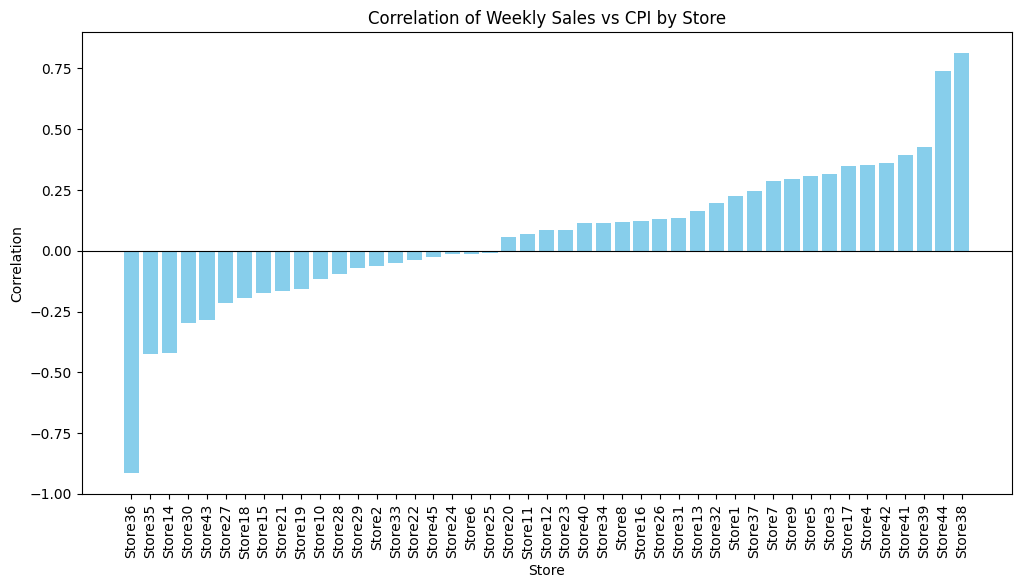

In [30]:
# Plot the Weekly Sales to CPI correlation for all the stores
plt.figure(figsize=(12,6))
plt.bar(store_cpi_corr_sorted.index, store_cpi_corr_sorted['weeklysales_cpi_corr'], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Correlation of Weekly Sales vs CPI by Store")
plt.xlabel("Store")
plt.ylabel("Correlation")
plt.xticks(rotation=90)
plt.show()

**Inference (1.d):** There are 20 stores negatively impacted due to CPI - Store 36 is the most affected.
There are 25 stores positively impacted by CPI - Store number 38 and 44 are the most impacted.

**1.e. Top performing stores according to the historical data.**

In [31]:
# Aggregate the sum of all weakly sales for all years at store level
series_weekly_store_aggregated_sales = df_sales.groupby('store')['weekly_sales'].sum().sort_values(ascending=False)
print("Top 10 performing stores::")
series_top10_stores = series_weekly_store_aggregated_sales.head(10)
series_top10_stores

Top 10 performing stores::


,weekly_sales
store,
20,3.013978e+08
4,2.995440e+08
14,2.889999e+08
13,2.865177e+08
2,2.753824e+08
10,2.716177e+08
27,2.538559e+08
6,2.237561e+08
1,2.224028e+08


**1.f. The worst performing store, and how significant is the difference between the highest and lowest performing stores**

In [32]:
print("Bottom 10 performing stores::")
series_bottom10_stores = series_weekly_store_aggregated_sales.tail(10)
series_bottom10_stores

Bottom 10 performing stores::


,weekly_sales
store,
29,77141554.31
16,74252425.40
37,74202740.32
30,62716885.12
3,57586735.07
38,55159626.42
36,53412214.97
5,45475688.90
44,43293087.84


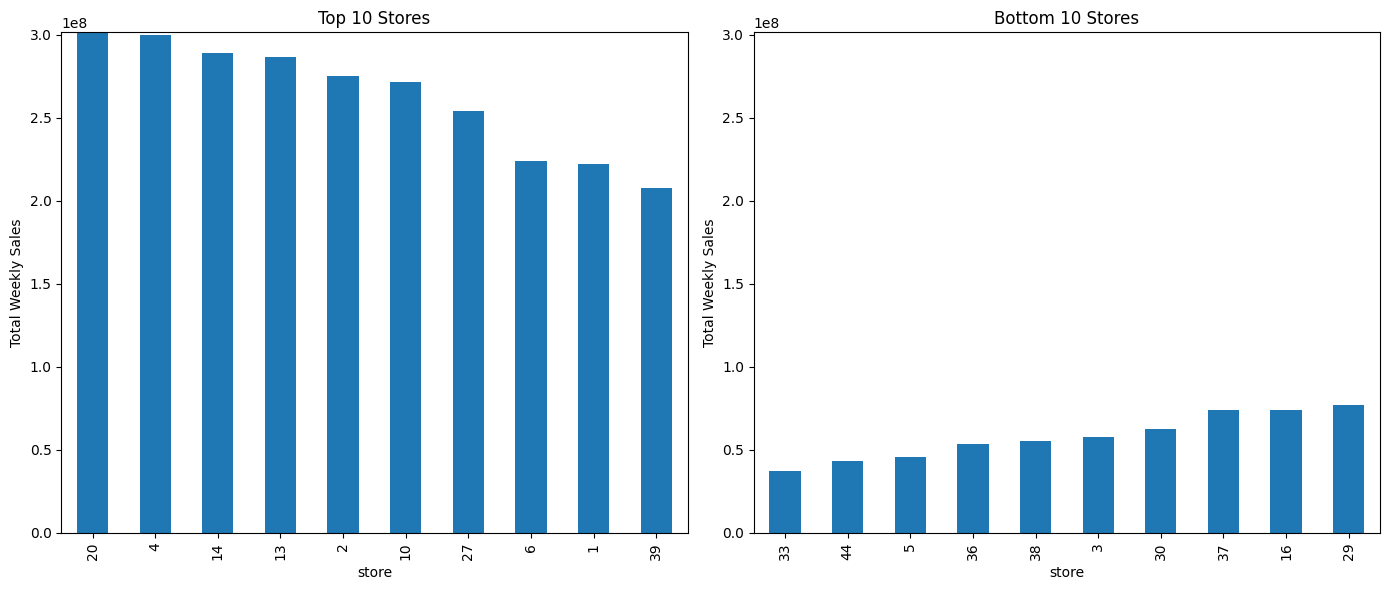

In [33]:
# Plot Top 10 and Bottom 10 performing stores

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Top 10
series_top10_stores.nlargest(10).plot(kind='bar', ax=axes[0])
axes[0].set_title("Top 10 Stores")
axes[0].set_ylabel("Total Weekly Sales")
axes[0].set_ylim(0, series_top10_stores.max())  # force same scale

# Bottom 10
series_bottom10_stores.nsmallest(10).plot(kind='bar', ax=axes[1])
axes[1].set_title("Bottom 10 Stores")
axes[1].set_ylabel("Total Weekly Sales")
axes[1].set_ylim(0, series_top10_stores.max())  # force same scale

plt.tight_layout()
plt.show()


In [34]:
# calculate the difference of weekly sales between the best and the worst performing store
best_store = series_weekly_store_aggregated_sales.idxmax()
best_sales = series_weekly_store_aggregated_sales.max()
print(f"The Best performing Store is::{best_store} with aggregated sales of {best_sales}")

The Best performing Store is::20 with aggregated sales of 301397792.46


In [35]:
# calculate the difference of weekly sales between the best and the worst performing store
worst_store = series_weekly_store_aggregated_sales.idxmin()
worst_sales = series_weekly_store_aggregated_sales.min()
print(f"The Worst performing Store is::{worst_store} with aggregated sales of {worst_sales}")

The Worst performing Store is::33 with aggregated sales of 37160221.96


In [36]:
print(f"The difference of sales between the best and the worst performing store is {best_sales - worst_sales}")
print(f"Best Store is {(best_sales/worst_sales)*100} % ahead of the worst store in terms of Sales")


The difference of sales between the best and the worst performing store is 264237570.49999997
Best Store is 811.0764052605244 % ahead of the worst store in terms of Sales


**Inference (1.f):** The best performing store in terms of total sales from 2010-2012 is 20 and the worst performing store is 33. There is a remarkable difference in the weekly sales of both stores with Store 20 ahead of Store 33 by a whooping 811%.

In [37]:
# Check total sales by Stores here
series_weekly_store_aggregated_sales.head(10)

,weekly_sales
store,
20,3.013978e+08
4,2.995440e+08
14,2.889999e+08
13,2.865177e+08
2,2.753824e+08
10,2.716177e+08
27,2.538559e+08
6,2.237561e+08
1,2.224028e+08


# Model Building and optimization for 1 random store

In [38]:
# Take a randome store = 20 and check staionarity first.
random_store = 20

df_store_data = df_sales[df_sales['store']==random_store]
result = adfuller(df_store_data['weekly_sales'])
p_val=result[1] #p-value
print(p_val)
if (p_val<0.05):
  print(f"We accept the Null Hypothesis - Data is stationary for Store : {random_store} ")
else:
  print(f"We reject the Null Hypothesis - Data is not stationary for store : {random_store}")

3.4912952838128377e-06
We accept the Null Hypothesis - Data is stationary for Store : 20 


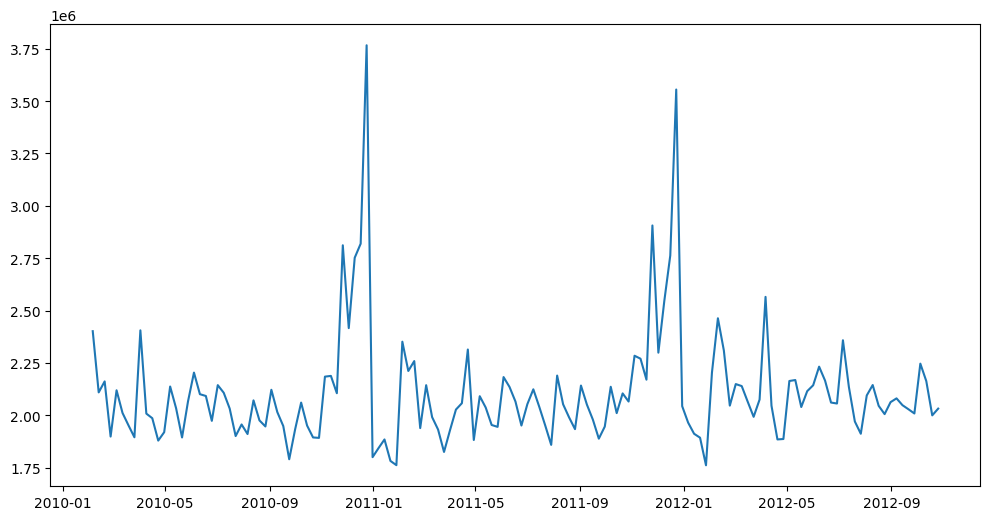

In [39]:
plt.figure(figsize=(12,6))
plt.plot(df_store_data.index, df_store_data['weekly_sales'])

In [40]:
# Data is stationary so we can proceed to ARIMA
# Quick way to judge p,d,q value is to do Auto ARIMA

model = auto_arima(df_store_data['weekly_sales'], trace=True, suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3974.854, Time=2.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3991.763, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3971.424, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3977.707, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4574.703, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3972.263, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3972.813, Time=0.85 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3974.255, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.640 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1982.712
Date:                Wed, 04 Feb 2026   AIC                           3971.424
Time:                        15:56:54   BIC                           3980.313
Sample:                    02-05-2010   HQIC                          3975.036
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.304e+06   1.01e+05     12.964      0.000    1.11e+06     1.5e+06
ar.L1          0.3815      0.038     10.058      0.000       0.307       0.456
sigma2      6.452e+10      0.934   6.91e+10      0.000    6.45e+10    6.45e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               674.61
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.98
Prob(H) (two-sided):                  0.17   Kurtosis:                        12.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.12e+25. Standard errors may be unstable.
"""

In [41]:
model.order

(1, 0, 0)

In [42]:
# take the first 100 rows (all 2010 and 2011 entries) to train and the rest for testing
train = df_store_data['weekly_sales'][:100]
test = df_store_data['weekly_sales'][100:]


In [43]:
model = ARIMA(train, order=model.order)
model = model.fit()
model.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1399.264
Date:                Wed, 04 Feb 2026   AIC                           2804.528
Time:                        15:56:54   BIC                           2812.343
Sample:                    02-05-2010   HQIC                          2807.691
                         - 12-30-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.116e+06   6.51e+04     32.521      0.000    1.99e+06    2.24e+06
ar.L1          0.3886      0.051      7.597      0.000       0.288       0.489
sigma2      8.345e+10      0.460   1.81e+11      0.000    8.34e+10    8.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               305.27
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+26. Standard errors may be unstable.
"""

In [44]:
#predict for test data
start = len(train)
end = len(train) + len(test) - 1
print(f"Start={start},, End = {end}")

pred = model.predict(start=start, end=end, typ='levels')
pred

Start=100,, End = 142


,predicted_mean
2012-01-06,2.087546e+06
2012-01-13,2.104761e+06
2012-01-20,2.111450e+06
2012-01-27,2.114049e+06
2012-02-03,2.115059e+06
2012-02-10,2.115451e+06
2012-02-17,2.115604e+06
2012-02-24,2.115663e+06
2012-03-02,2.115686e+06
2012-03-09,2.115695e+06


In [45]:
# Get predicted and actual value in a dataframe
pred_df = pd.DataFrame({'predicted':pred, 'actual':test})
pred_df

,predicted,actual
2012-01-06,2.087546e+06,1964701.94
2012-01-13,2.104761e+06,1911510.64
2012-01-20,2.111450e+06,1892775.94
2012-01-27,2.114049e+06,1761016.51
2012-02-03,2.115059e+06,2203523.20
2012-02-10,2.115451e+06,2462978.28
2012-02-17,2.115604e+06,2309025.16
2012-02-24,2.115663e+06,2045837.55
2012-03-02,2.115686e+06,2148822.76
2012-03-09,2.115695e+06,2139265.40


In [46]:
rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)
print(f"RMSE = {rmse}, MAE = {mae}")

RMSE = 150364.73917026474, MAE = 113840.02282651601


The Error Looks Ok but lets try SARIMAX because we can see there is a seasonality angle to it (Nov-Dec high sales, Jan Sales drop).

In [47]:

# Define SARIMAX model
# order = (p,d,q) from auto_arima
# seasonal_order = (P,D,Q,s) where s = seasonal period (52 for weekly data)
model = SARIMAX(train,
                order=(1,0,0),
                seasonal_order=(1,1,1,52),   # captures yearly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model = model.fit(disp=False)

# Model summary
print(model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                         weekly_sales   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 52)   Log Likelihood                   0.000
Date:                              Wed, 04 Feb 2026   AIC                              8.000
Time:                                      15:57:01   BIC                                nan
Sample:                                  02-05-2010   HQIC                               nan
                                       - 12-30-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1155         -0       -inf      0.000       0.115       0.115
ar.S.L52           

In [48]:
pred = model.predict(start=test.index[0], end=test.index[-1], dynamic=False)
pred


,predicted_mean
2012-01-06,1.871151e+06
2012-01-13,1.887592e+06
2012-01-20,1.782181e+06
2012-01-27,1.761550e+06
2012-02-03,2.351148e+06
2012-02-10,2.211389e+06
2012-02-17,2.258616e+06
2012-02-24,1.938609e+06
2012-03-02,2.143425e+06
2012-03-09,1.990933e+06


In [49]:
# Get predicted and actual value in a dataframe
pred_df = pd.DataFrame({'predicted':pred, 'actual':test})
pred_df

,predicted,actual
2012-01-06,1.871151e+06,1964701.94
2012-01-13,1.887592e+06,1911510.64
2012-01-20,1.782181e+06,1892775.94
2012-01-27,1.761550e+06,1761016.51
2012-02-03,2.351148e+06,2203523.20
2012-02-10,2.211389e+06,2462978.28
2012-02-17,2.258616e+06,2309025.16
2012-02-24,1.938609e+06,2045837.55
2012-03-02,2.143425e+06,2148822.76
2012-03-09,1.990933e+06,2139265.40


In [50]:
rmse_SARIMAX = mean_squared_error(test, pred)
mae_SARIMAX = mean_absolute_error(test, pred)
print(f"RMSE = {rmse_SARIMAX}, MAE = {mae_SARIMAX}")

RMSE = 22147147627.64153, MAE = 108802.04160861303


In [51]:
#Checking improvement between ARIMA and SARIMAX in MAE
print(f"Percentage Improvement in MAE after SARIMAX = {((mae - mae_SARIMAX)/rmse)*100} %")


Percentage Improvement in MAE after SARIMAX = 3.3505070708088356 %


# # Automate Model Creation for 5 random stores.

In [52]:
#Lets automate this for the 5 random stores we have chosen
# First check Stationarity for all Stores. For the sake of simplicity, we will remove the
# stores with non stationary data. For non-stationary data, differencing is required but we will remove those kind of stores from the random store list after doing stationarity test.
random_stores = [20,33,1,15,43]
for s in random_stores:
  df_store_data = df_sales[df_sales['store']==s]
  result = adfuller(df_store_data['weekly_sales'])
  p_val=result[1] #p-value
  print(p_val)
  if (p_val<0.05):
    print(f"We accept the Null Hypothesis - Data is stationary for Store number:{s}")
  else:
    print(f"We reject the Null Hypothesis - Data is not stationary for Store number:{s}")
    non_stationary_store = s
    break;
print(f"Removing store {s} from the random list.")
random_stores.remove(non_stationary_store)
random_stores


3.4912952838128377e-06
We accept the Null Hypothesis - Data is stationary for Store number:20
0.0008379552269735709
We accept the Null Hypothesis - Data is stationary for Store number:33
1.3877788330759434e-05
We accept the Null Hypothesis - Data is stationary for Store number:1
1.5100158829353333e-06
We accept the Null Hypothesis - Data is stationary for Store number:15
0.10605876999786595
We reject the Null Hypothesis - Data is not stationary for Store number:43
Removing store 43 from the random list.


[20, 33, 1, 15]

**We are left with 4 stores since data of Store 43 was not stationary.**

In [53]:
rmse ={}; # Dictionary to capture RMSE of each store's model.
mae = {}; # Dictionary to capture MAE of each store's model.
pred_v_actual_dict = {} # Dictionary to capture pred_v_actual value dataframes of each store's model.
model_dict ={} # Dictionary to store models of each store's model.
# For each of the above dictionaries, store_id will be the key

for s in random_stores:
  df_store_data = df_sales[df_sales['store']==s]
   # take the first 100 rows (all 2010 and 2011 entries) to train and the rest for testing
  train = df_store_data['weekly_sales'][:100]
  test = df_store_data['weekly_sales'][100:]
  print(f"====================== Store number {s} ====================== ")
  #model = auto_arima(df_store_data['weekly_sales'],trace=False, suppress_warnings=True)
  model_dict[s] = auto_arima(train,trace=False, D =1, m=52, suppress_warnings=True)
  model_dict[s].summary()
  print (f"p,d,q Order = {model_dict[s].order}")
  print (f"Seasonal Order = {model_dict[s].seasonal_order}")


  model_dict[s] = SARIMAX(train,
                order = model_dict[s].order,
                seasonal_order = model_dict[s].seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend='c')

  # Fit the model
  model_dict[s] = model_dict[s].fit(disp=False)

  # Model summary
  #print(model.summary())
  pred = model_dict[s].predict(start=test.index[0], end=test.index[-1], dynamic=False)
  pred_v_actual_dict[s] = pd.DataFrame({'predicted':pred, 'actual':test})
  # calculate RMSE and MAE
  rmse[s] = np.sqrt(mean_squared_error(test, pred))
  mae[s] = mean_absolute_error(test, pred)
  print(f"RMSE = {rmse[s]}, MAE = {mae[s]}")
  #print(pred_v_actual_dict[s])

====================== Store number 20 ====================== 
p,d,q Order = (0, 0, 0)
Seasonal Order = (0, 1, 0, 52)
RMSE = 142521.0316355412, MAE = 101268.79812984496
====================== Store number 33 ====================== 


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


p,d,q Order = (1, 1, 1)
Seasonal Order = (1, 1, 0, 52)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


RMSE = 386065.9285032535, MAE = 318753.8723822254
====================== Store number 1 ====================== 
p,d,q Order = (0, 0, 0)
Seasonal Order = (0, 1, 0, 52)
RMSE = 70390.60345159778, MAE = 52253.85683139534
====================== Store number 15 ====================== 


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


p,d,q Order = (0, 0, 0)
Seasonal Order = (0, 1, 0, 52)
RMSE = 43484.164771818156, MAE = 33551.34472383723


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [54]:
# Generic method to plot the predicted versus actual values from the dictionary of dataframes of stores

def plot_pred_v_actual(pred_v_actual_dict):

  # Number of stores
  n_stores = len(pred_v_actual_dict)

  # Create subplots (4*1 grid for 4 stores)
  fig, axes = plt.subplots(2, 2, figsize=(20, 2*n_stores), sharex=False, sharey=False)

  # Flatten axes for easy iteration
  axes = axes.flatten()

  # Loop through dictionary
  for i, (store_id, df) in enumerate(pred_v_actual_dict.items()):
      ax = axes[i]
      ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
      ax.plot(df.index, df['actual'], label='Actual', color='orange')
      ax.plot(df.index, df['predicted'], label='Predicted', color='green')
      ax.set_title(f'Store {store_id}. RMSE: {rmse[store_id]}. MAE:{mae[store_id]}')
      ax.set_xlabel('Date')
      ax.set_ylabel('Weekly Sales')
      ax.legend()

  plt.suptitle('Actual vs Predicted Weekly Sales for 4 Stores', fontsize=16)
  plt.tight_layout()
  plt.show()

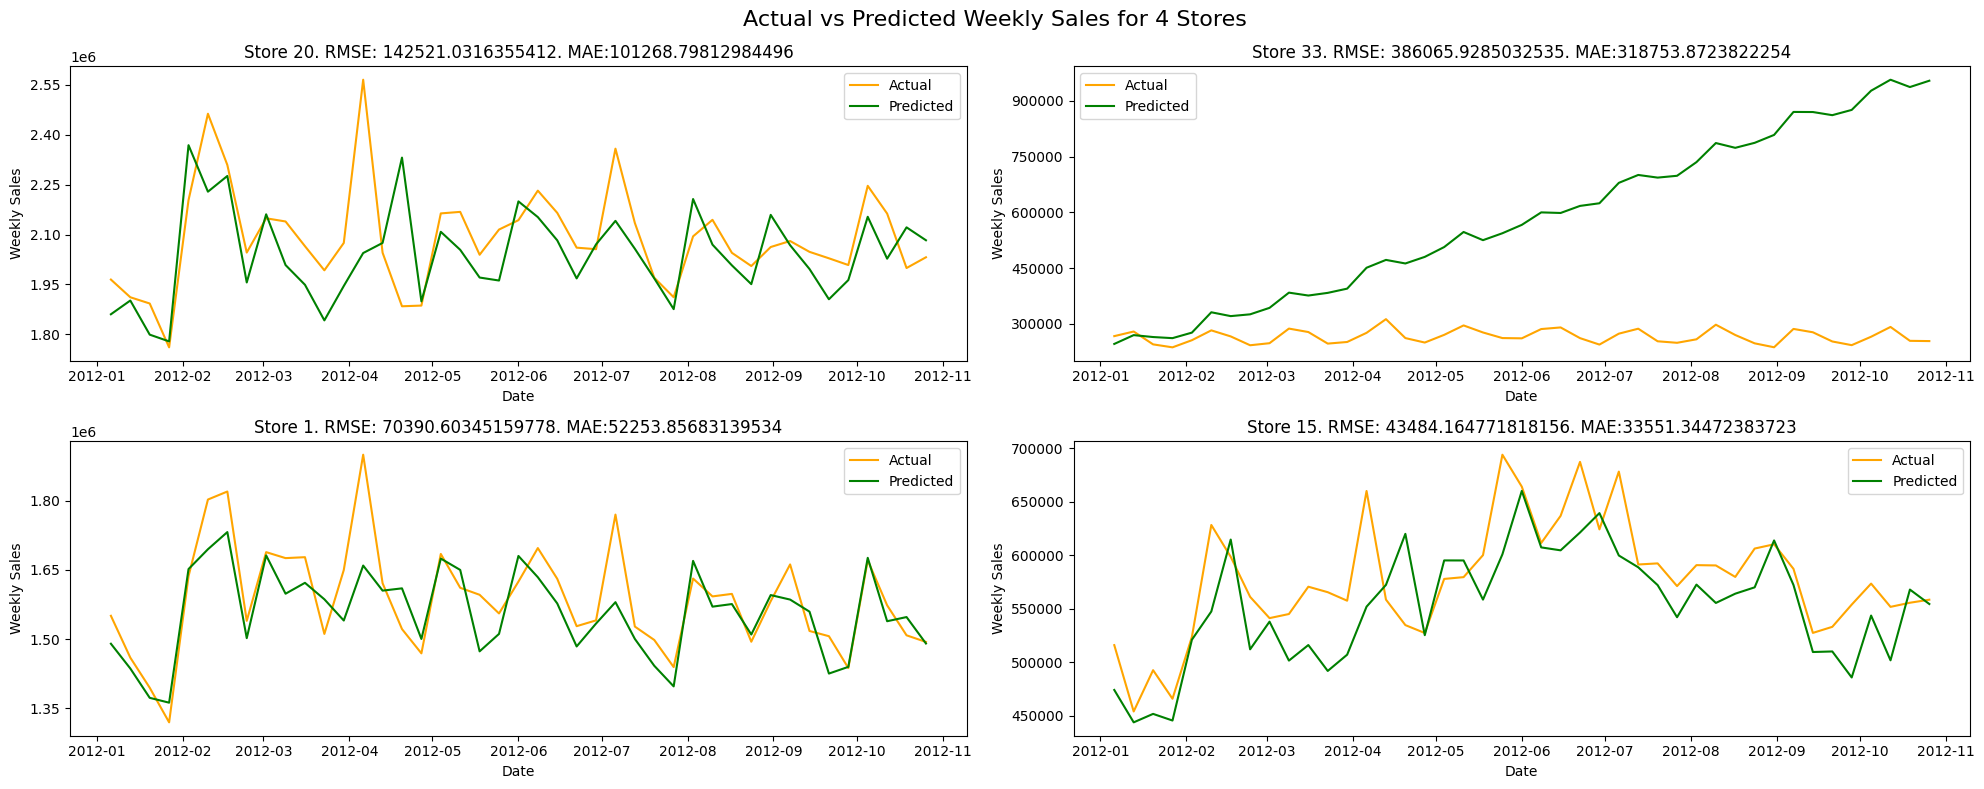

In [55]:
plot_pred_v_actual(pred_v_actual_dict)

**We can see Store number 33 does not fit its model.** That is because unlike other stores, it does not have a 52 weeks seasonality.
Observing the actual values in orange in the plot for store 33, we can see peaks every 3-4 weeks. So lets test AutoArima with m=3 instead of 52.

In [56]:
# Preparing customized model for Store 33.
store_id = 33
df_store_data = df_sales[df_sales['store']==store_id]

# take the first 100 rows (all 2010 and 2011 entries) to train and the rest for testing
train = df_store_data['weekly_sales'][:100]
test = df_store_data['weekly_sales'][100:]
print(f"====================== Store number {store_id} ====================== ")
model_dict[store_id] = auto_arima(train, trace=False, seasonal=True, m=3, D=1, suppress_warnings=True)
#model.summary()
print (f"Order = {model_dict[store_id].order}")
print (f"Seasonal Order = {model_dict[store_id].seasonal_order}")

model_dict[store_id] = SARIMAX(train,
              order = model_dict[store_id].order,
              seasonal_order=model_dict[store_id].seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)

model_dict[store_id] = model_dict[store_id].fit()

# Model summary
#print(model.summary())
pred = model_dict[store_id].predict(start=test.index[0], end=test.index[-1], dynamic=True)
# Lift the peaks up by adjusting biasness
bias = (test - pred).mean()
pred = pred + bias

pred_v_actual_dict[store_id] = pd.DataFrame({'predicted':pred, 'actual':test})
# calculate RMSE and MAE
rmse[store_id] = np.sqrt(mean_squared_error(test, pred))
mae[store_id]  = mean_absolute_error(test, pred)
print(f"RMSE = {rmse[store_id] }, MAE = {mae[store_id] }")


====================== Store number 33 ====================== 
Order = (2, 0, 2)
Seasonal Order = (2, 1, 1, 3)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


RMSE = 18282.567476130036, MAE = 15444.503607322084


**Lets plot the graphs of the 4 random stores again with modified Store 33 model prediction**

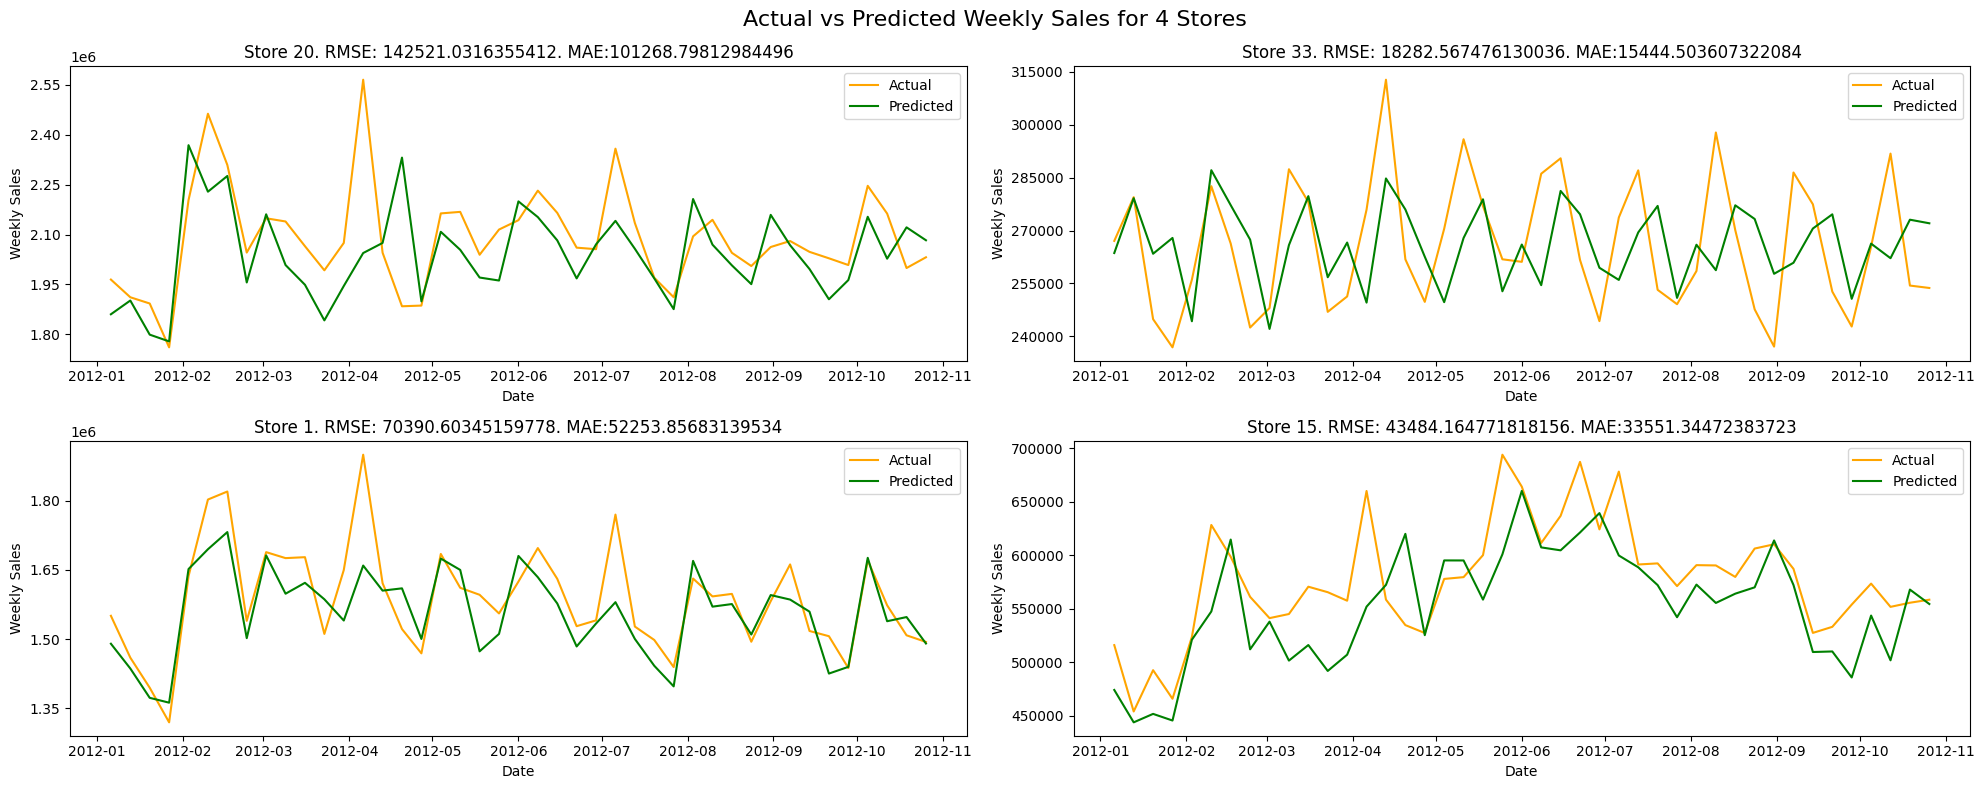

In [57]:
plot_pred_v_actual(pred_v_actual_dict)

# Forecasting using the store models.

**# Forecasting next 12 weeks for a store (Out of the 4 random stores chosen: 20, 33, 1,15)**

In [61]:
# Define a generic forecasting function

def forecast_next_12_weeks(store_id, model_dict, df_sales):
    """
    Forecast next 12 weeks of sales for a given store using its SARIMAX model.

    Parameters:
    - store_id: int, store number
    - model_dict: dict, pre-trained SARIMAX models keyed by store_id
    - df_sales: pd.DataFrame, full sales data with 'store' and 'weekly_sales' columns

    Returns:
    - forecast: pd.Series with 12 weeks of predicted sales, indexed by future dates
    """
    # Chek if storeid is in the keys of model_dict. If no print error and return.
    if store_id not in model_dict:
        print(f"No model found for store {store_id}")
        return

    # Extract store data
    df_store_data = df_sales[df_sales['store'] == store_id]

    # Get the model
    model = model_dict[store_id]

    # Find last observed date
    last_date = df_store_data.index.max()

    # Create future weekly dates for 12 weeks ahead
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                                 periods=12, freq='W')

    # Forecast using predict (start after last observation)
    forecast = model.predict(start=len(df_store_data), end=len(df_store_data)+11)
    forecast.index = future_dates
    forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_mean': forecast.values})
    # Rename column
    forecast_df.rename(columns={'predicted_mean': 'predicted_value'}, inplace=True)

    # Convert scientific notation to readable numeric format
    forecast_df['predicted_value'] = forecast_df['predicted_value'].round(3)

    return forecast_df

In [59]:
#Forecast for a Store not in the random list. Exception Flow.
forecast_next_12_weeks(200, model_dict, df_sales)

No model found for store 200


In [60]:
#Forecast for a Store which is in the random list.
forecast_next_12_weeks(20, model_dict, df_sales)

,date,predicted_value
0,2012-11-04,2301465.628
1,2012-11-11,2287334.878
2,2012-11-18,2187292.848
3,2012-11-25,2923592.278
4,2012-12-02,2316135.858
5,2012-12-09,2563482.808
6,2012-12-16,2780175.678
7,2012-12-23,3572730.058
8,2012-12-30,2060604.028
9,2013-01-06,1877749.006


# Summary

1.   The Walmart Weekly Sales Analysis data shows seasonal weakly sales peaks at specific times of the year especially Nov - Dec for most stores. Both Aggregated Weekly Sales Plot of 3 randomly chosen stores and Aggregated Sales of Walmart across all stores confirm the same.
2. SARIMAX showed 3 % improvement than regular ARIMA in MAE (Mean Absolute Error) when modelling one randomly selected store number 20.
3.   Observing the above points, 4 randomly chosen stores [20,33,1,15] were modelled using AutoArima and SARIMAX with yearly seasonality (seasonal order = 1,1,1,52)
4. Out of the above four stores, Store 33 showed considerable deviation between predicted and actual Values.

    a. On observing the actual values further on the plot, it was observed that store 33 did not have the same seasoanlity as compared to the other 3 stores and the weakly sales of the store was peaking every 3-4 weeks.

    b. Store 33 was then remodelled with seasonal order m=3 instead of 52 and a bias adjustement of predicted value, where the bias = (test -pred).mean. Without the bias adjustment, the peak predictions were always lower than the actual values.
5.  All 4 random stores have been modelled succesfully and a generic forecast method is written to forecast the next 12 weeks with store_id as input.
